# Preparations

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import geopy.distance as distance
from data_analysis import load_data, combine_data, merge
import seaborn as sns
import scipy.stats as stats

In [2]:
def plotregion(m, df, linecolor='#00ff00'):
    df = df.dropna(subset=['temp', 'humidity'])
    line = df[['lat', 'lon']].values
    if len(line):
        folium.PolyLine(line, color=linecolor).add_to(m)

    for lat, lon, temp, humidity, distance in df[['lat', 'lon', 'temp', 'humidity', 'distance']].values:
        #color = f'#{int(temp / 20 * 256):02x}00{int(humidity / 100 * 256):02x}'
        color = f'#{int(distance / 150 * 255):02x}00{int((1 - distance / 255) * 256):02x}'
        folium.CircleMarker(location=[lat, lon], radius=5, color=color, fill_opacity=1, fill=True, stroke=False).add_to(m)


# Sanity Checks

In [3]:
m = folium.Map(tiles="Stadia.AlidadeSatellite", location=[42.446, -78.2155], zoom_start=18)
dates = ['04-03', '04-07']
all_ground = []
all_below_samples = []
all_above_samples = []
for date in dates:
    for transect in range(1, 4):
        ground, below_samples, above_samples = load_data(transect, date)
        all_ground.append(ground)
        all_below_samples.append(below_samples)
        all_above_samples.append(above_samples)
        plotregion(m, below_samples)
        plotregion(m, above_samples)
all_ground = pd.concat(all_ground, axis=0)
all_below_samples = pd.concat(all_below_samples, axis=0)
all_above_samples = pd.concat(all_above_samples, axis=0)
m

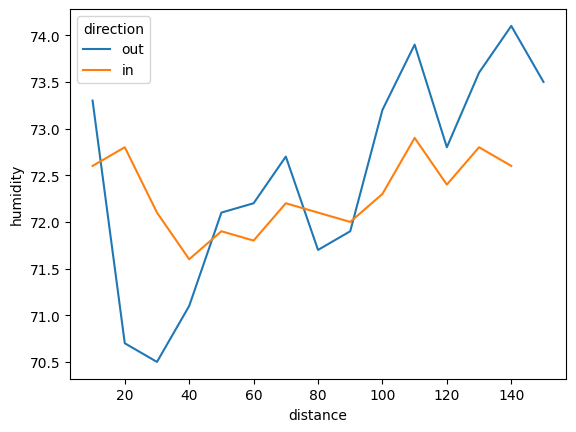

In [4]:
_, below_samples, _ = load_data(3, '04-10')
sns.lineplot(below_samples, x='distance', y='humidity', hue='direction');

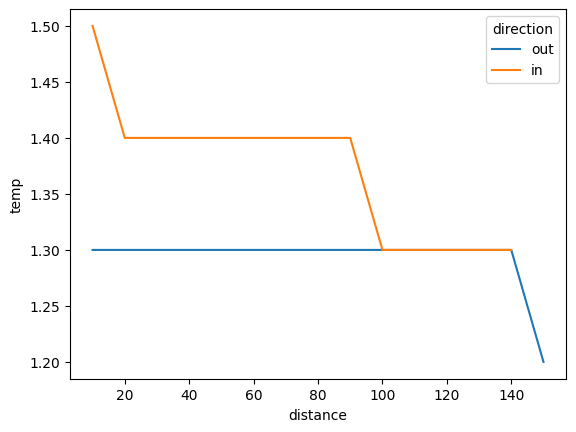

In [5]:
sns.lineplot(below_samples, x='distance', y='temp', hue='direction');

# Combine Data

/tmp/ipykernel_10419/2799641226.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  below_samples.query('distance < 150').groupby('distance').apply(lambda g: distance.distance(*g[['lat', 'lon']].values).meters).plot();


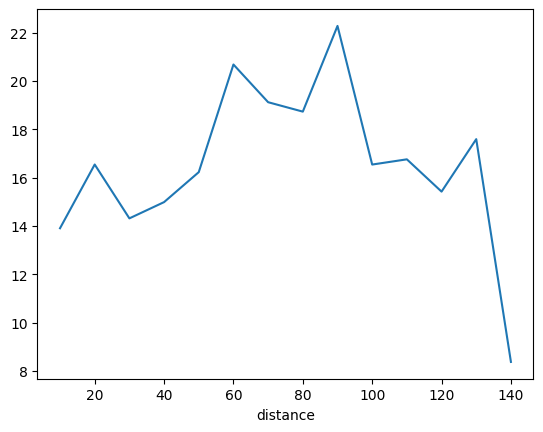

In [6]:
below_samples.query('distance < 150').groupby('distance').apply(lambda g: distance.distance(*g[['lat', 'lon']].values).meters).plot();

In [7]:
merged = merge(combine_data(all_below_samples), combine_data(all_above_samples), ('_below', '_above'))

In [8]:
all_data = merge(all_ground.groupby(['date', 'transect', 'distance']).apply(lambda g: g.iloc[0][['soil_temperature', 'soil moisture']]), merged, ('_ground', ''))

/tmp/ipykernel_10419/120018851.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_data = merge(all_ground.groupby(['date', 'transect', 'distance']).apply(lambda g: g.iloc[0][['soil_temperature', 'soil moisture']]), merged, ('_ground', ''))


# Tests

## 1 Tests

In [9]:
stats.bartlett(*all_data[['soil_temperature', 'temp_below', 'temp_above']].values.T, nan_policy='omit')

BartlettResult(statistic=np.float64(2.603232398936852), pvalue=np.float64(0.2720916830435491))

In [10]:
stats.f_oneway(*all_data[['soil_temperature', 'temp_below', 'temp_above']].values.T, nan_policy='omit')

F_onewayResult(statistic=np.float64(116.10892449961887), pvalue=np.float64(2.8330224960062355e-36))

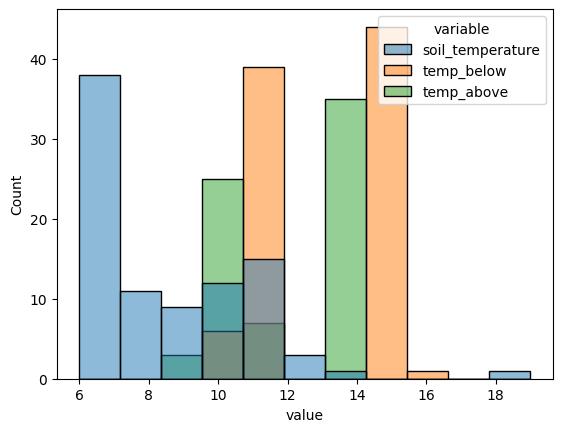

In [11]:
sns.histplot(all_data.melt(value_vars=['soil_temperature', 'temp_below', 'temp_above']), x='value', hue='variable');

In [12]:
stats.bartlett(*all_data[['humidity_below', 'humidity_above']].values.T, nan_policy='omit')

BartlettResult(statistic=np.float64(0.3352822913213849), pvalue=np.float64(0.562565114274366))

In [13]:
stats.f_oneway(*all_data[['humidity_below', 'humidity_above']].values.T, nan_policy='omit')

F_onewayResult(statistic=np.float64(0.045021898661235904), pvalue=np.float64(0.8322372470117101))

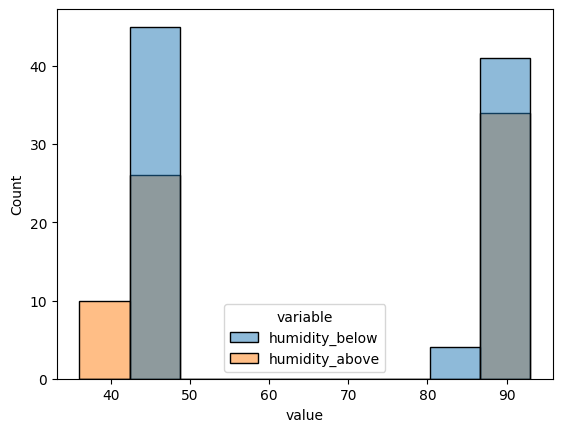

In [14]:
sns.histplot(all_data.melt(value_vars=['humidity_below', 'humidity_above']), x='value', hue='variable');

## 2 Tests

In [15]:
all_data.dropna(inplace=True)

In [16]:
stats.pearsonr(*all_data[['temp_below', 'temp_above']].values.T)

PearsonRResult(statistic=np.float64(0.921884177787232), pvalue=np.float64(1.0427368817666931e-29))

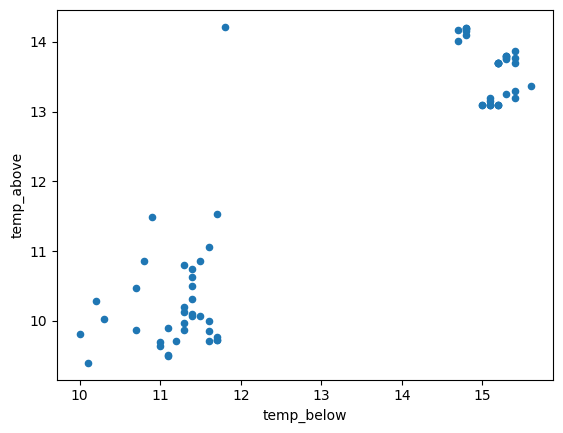

In [17]:
all_data.plot.scatter(x='temp_below', y='temp_above');

In [18]:
stats.pearsonr(*all_data[['soil_temperature', 'temp_below']].values.T)

PearsonRResult(statistic=np.float64(0.7931640564767799), pvalue=np.float64(2.7258704965960533e-16))

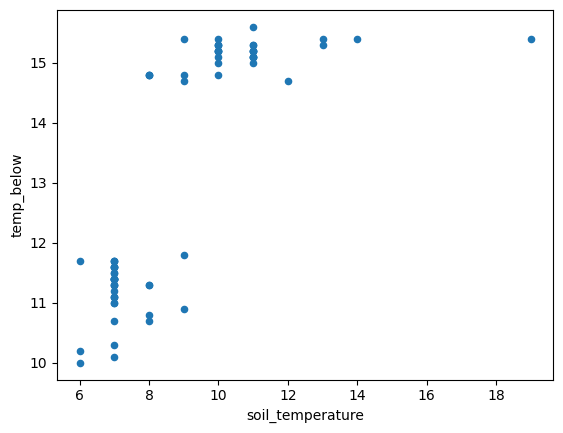

In [19]:
all_data.plot.scatter(x='soil_temperature', y='temp_below');

In [20]:
stats.pearsonr(*all_data[['humidity_below', 'humidity_above']].values.T)

PearsonRResult(statistic=np.float64(0.9967038101119539), pvalue=np.float64(6.43518947092612e-76))

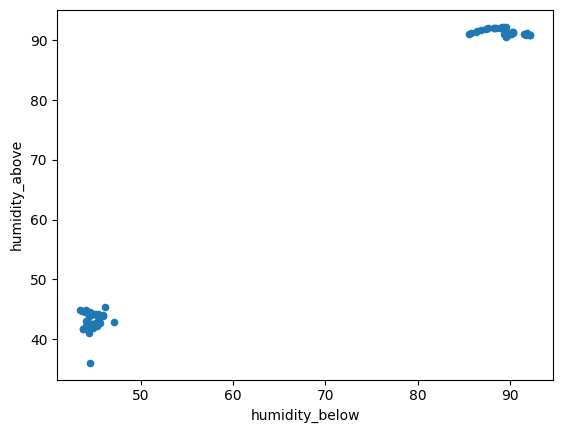

In [21]:
all_data.plot.scatter(x='humidity_below', y='humidity_above');

## 3 Tests

### Temperature

In [22]:
stats.pearsonr(*all_ground[['distance', 'soil_temperature']].values.T)

PearsonRResult(statistic=np.float64(-0.15207614283431067), pvalue=np.float64(0.15246139610728965))

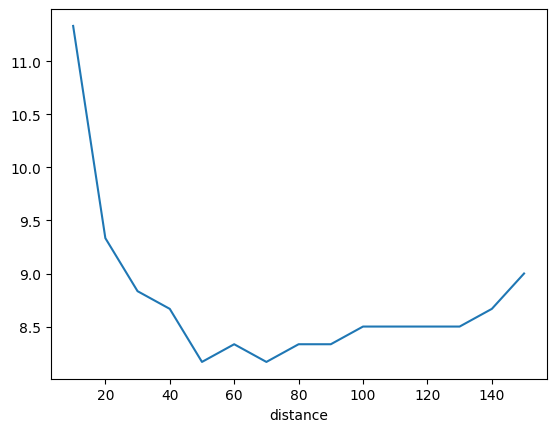

In [23]:
all_ground.groupby('distance')['soil_temperature'].mean().plot();

In [24]:
stats.pearsonr(*all_below_samples[['distance', 'temp']].values.T)

PearsonRResult(statistic=np.float64(-0.0022347939667830864), pvalue=np.float64(0.9833216134525083))

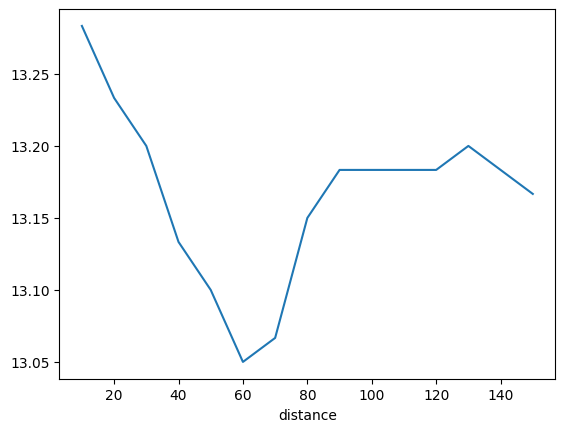

In [25]:
all_below_samples.groupby('distance')['temp'].mean().plot();

In [26]:
stats.pearsonr(*all_above_samples[['distance', 'temp']].values.T)

PearsonRResult(statistic=np.float64(-0.3414667000263127), pvalue=np.float64(1.5419208174774474e-10))

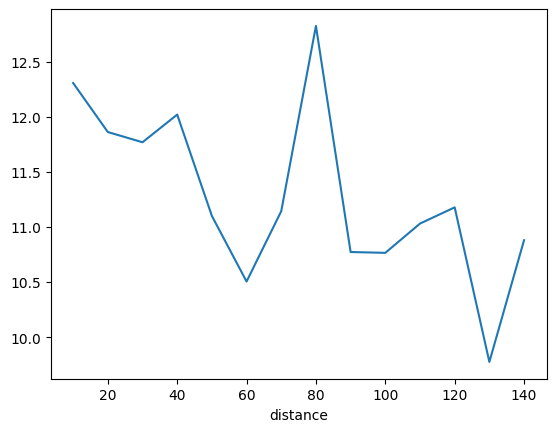

In [27]:
all_above_samples.groupby('distance')['temp'].mean().plot();

### Humidity

In [28]:
stats.pearsonr(*all_below_samples[['distance', 'humidity']].values.T)

PearsonRResult(statistic=np.float64(0.013907414510056566), pvalue=np.float64(0.8964878563005318))

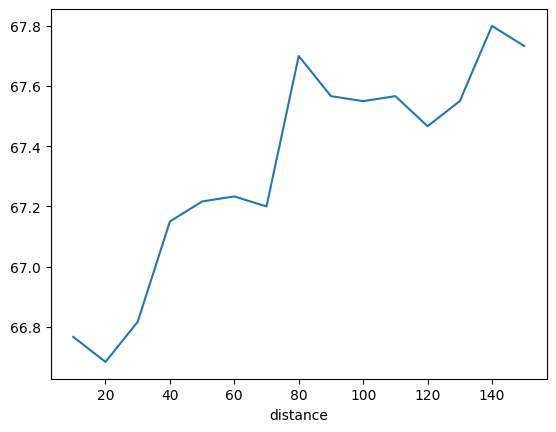

In [29]:
all_below_samples.groupby('distance')['humidity'].mean().plot();

In [30]:
stats.pearsonr(*all_above_samples[['distance', 'humidity']].values.T)

PearsonRResult(statistic=np.float64(-0.07332668463600955), pvalue=np.float64(0.18192463753269608))

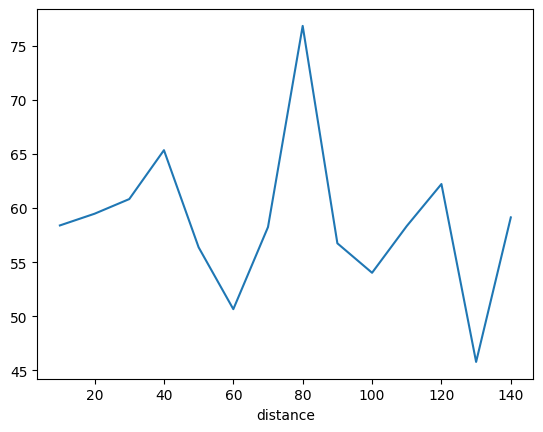

In [31]:
all_above_samples.groupby('distance')['humidity'].mean().plot();

## 4 Tests

In [36]:
all_data.eval('temp_above_below = temp_above - temp_below', inplace=True)
all_data.eval('temp_below_ground = temp_below - soil_temperature', inplace=True)
all_data.eval('temp_above_ground = temp_above - soil_temperature', inplace=True)
all_data.eval('humidity_above_below = humidity_above - humidity_below', inplace=True)
all_data.reset_index(inplace=True)

PearsonRResult(statistic=np.float64(-0.3973741914813284), pvalue=np.float64(0.000658680608551986))

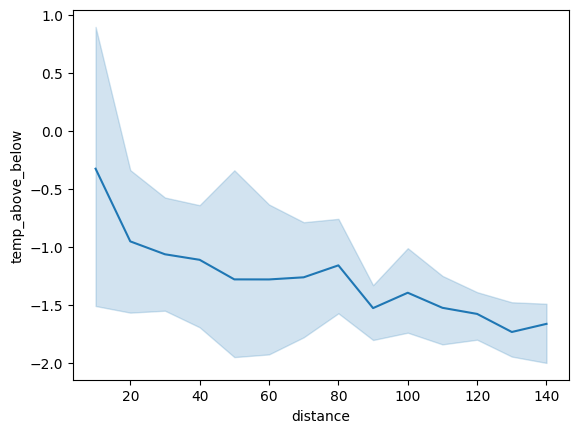

In [41]:
sns.lineplot(all_data, x='distance', y='temp_above_below')
stats.pearsonr(*all_data[['distance', 'temp_above_below']].values.T)

PearsonRResult(statistic=np.float64(0.2633682536423182), pvalue=np.float64(0.02760384795111641))

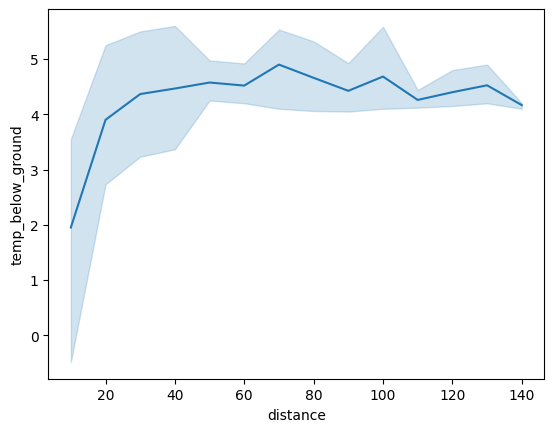

In [42]:
sns.lineplot(all_data, x='distance', y='temp_below_ground')
stats.pearsonr(*all_data[['distance', 'temp_below_ground']].values.T)

PearsonRResult(statistic=np.float64(0.040633690014302976), pvalue=np.float64(0.7383927610814836))

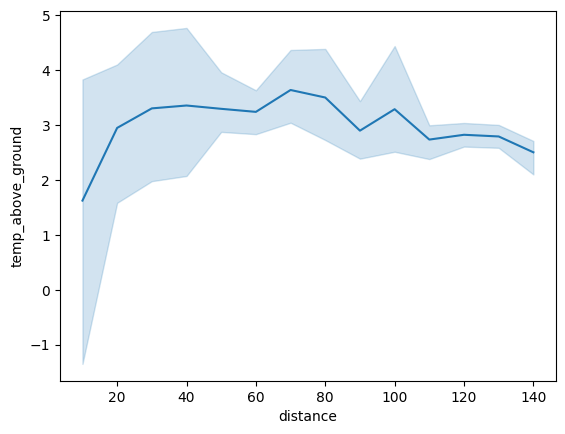

In [43]:
sns.lineplot(all_data, x='distance', y='temp_above_ground')
stats.pearsonr(*all_data[['distance', 'temp_above_ground']].values.T)

PearsonRResult(statistic=np.float64(0.06702678279977593), pvalue=np.float64(0.5814214951613603))

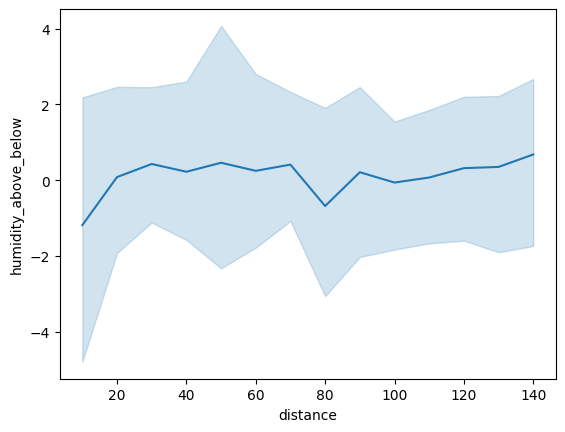

In [44]:
sns.lineplot(all_data, x='distance', y='humidity_above_below')
stats.pearsonr(*all_data[['distance', 'humidity_above_below']].values.T)